# GP Simulations 1D example

In [48]:
import sys
import math

import torch
import numpy as np
import matplotlib.pyplot as plt
import dsdl
import gpytorch
import tqdm

from torcheval.metrics import BinaryAUROC
from joblib import Parallel, delayed

sys.path.append("..")

from src._97_gpytorch import LogisticGPVI, GPModel, LogitLikelihood, PGLikelihood

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


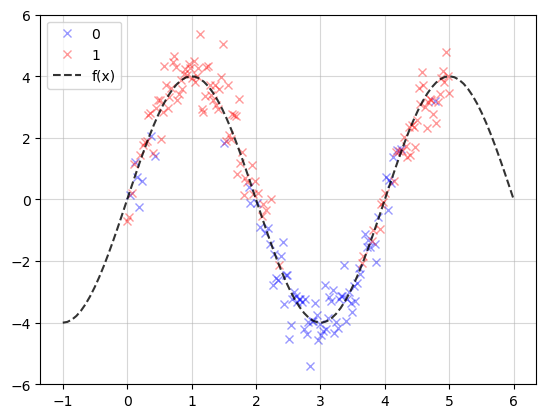

In [49]:
torch.manual_seed(0)

n = 200
train_x = torch.linspace(0, 5, n)
func = lambda x: torch.sin(x * (0.5 * math.pi)) * 4
train_f = torch.sin(train_x * (0.5 * math.pi)) * 4  + math.sqrt(0.4) * torch.randn(n)
train_x = train_x.reshape(-1, 1)

train_p = torch.sigmoid(train_f)
train_y = torch.bernoulli(train_p)

xs = torch.linspace(-1, 6, 100).reshape(-1, 1)

id0 = train_y == 0
id1 = train_y == 1

# plt.plot(train_x.detach().numpy(), train_f.detach().numpy(), 'xk', alpha=0.4)
plt.plot(train_x[id0].detach().numpy(), train_f[id0].detach().numpy(), 'xb', alpha=0.4)
plt.plot(train_x[id1].detach().numpy(), train_f[id1].detach().numpy(), 'xr', alpha=0.4) 
plt.plot(xs.detach().numpy(), func(xs).detach().numpy(), 'k--', alpha=0.8)
plt.grid(alpha=.5)
plt.ylim(-6, 6)
plt.legend(['0', '1', 'f(x)'])

In [52]:
f0 = LogisticGPVI(train_y, train_x, verbose=False, n_iter=500, thresh=1e-6)
f0.fit()
f0.runtime
f0.ELB0_MC()

tensor(55.9003)

In [53]:
likelihood = PGLikelihood()
f1 = LogisticGPVI(train_y, train_x, likelihood=likelihood, verbose=False, n_iter=500, thresh=1e-6)
f1.fit()
f1.runtime
f1.ELB0_MC()

tensor(53.9678)

In [60]:
test_x = torch.linspace(0, 5, 100)
test_f = func(test_x) + torch.randn(100) * math.sqrt(0.4)
test_p = torch.sigmoid((test_f))
test_y = torch.bernoulli(test_p)

In [100]:
test_x = test_x.reshape(-1, 1)
true_f = func(test_x)
auc = BinaryAUROC()

print("\nMK")
f0_pred = f0.model(test_x).mean
f0_lower, f0_upper = f0.model(test_x).confidence_region()
print( auc.update(f0.predict(test_x), test_y).compute().item())
print( f0.neg_log_likelihood().item())
print( ((true_f.reshape(-1) - f0_pred) ** 2).mean().item() )

print("\nPG")
f1_pred = f1.model(test_x).mean
f1_lower, f1_upper = f1.model(test_x).confidence_region()
print( auc.update(f1.predict(test_x), test_y).compute().item())
print( f1.neg_log_likelihood().item())
print( ((true_f.reshape(-1) - f1_pred) ** 2).mean().item() )


MK
0.8858784893267652
62.78914260864258
0.1455012857913971

PG
0.8878284072249589
63.25071716308594
0.2928156852722168


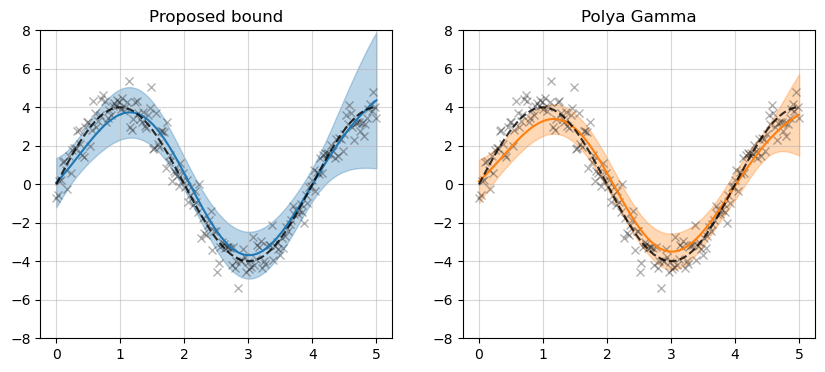

In [101]:
true_f = true_f.reshape(-1).detach().numpy()

with torch.no_grad():
    _, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].plot(train_x.numpy(), train_f.numpy(), 'kx', alpha=0.3)
    # ax[0].plot(train_x[id0].numpy(), train_f[id0].numpy(), 'xb', alpha=0.3)
    # ax[0].plot(train_x[id1].numpy(), train_f[id1].numpy(), 'xr', alpha=0.3)
    ax[0].plot(test_x.numpy(), f0_pred.numpy(), color='tab:blue')
    ax[0].fill_between(test_x.squeeze(1).numpy(), f0_lower.numpy(), f0_upper.numpy(), alpha=0.3, color='tab:blue')
    ax[0].plot(test_x.numpy(), true_f, 'k--', alpha=0.8)
    ax[0].set_ylim([-8, 8])
    ax[0].grid(True, alpha=0.5)
    ax[0].set_title("Proposed bound")

    ax[1].plot(train_x.numpy(), train_f.numpy(), 'kx', alpha=0.3)
    # ax[1].plot(train_x[id0].numpy(), train_f[id0].numpy(), 'xb', alpha=0.3)
    # ax[1].plot(train_x[id1].numpy(), train_f[id1].numpy(), 'xr', alpha=0.3)
    ax[1].plot(test_x.numpy(), f1_pred.numpy(), color='tab:orange')
    ax[1].fill_between(test_x.squeeze(1).numpy(), f1_lower.numpy(), f1_upper.numpy(), alpha=0.3, color='tab:orange')
    ax[1].plot(test_x.numpy(), true_f, 'k--', alpha=0.8)
    ax[1].set_ylim([-8, 8])
    ax[1].grid(True, alpha=0.5)
    ax[1].set_title("Polya Gamma")

    # ax[0].legend(['Observed Data', 'Mean', '95% CI', "Ground truth"])
    # ax[1].legend(['Observed Data', 'Mean', '95% CI', "Ground truth"])

plt.savefig("/home/michael/proj/papers/logistic_vb/figures/gp.pdf")

In [77]:
f0_lower, f0_upper = f0.credible_intervals(train_x)
f1_lower, f1_upper = f1.credible_intervals(train_x)

print( torch.sum( (train_f > f0_lower) & (train_f < f0_upper) ) / n )
print( torch.sum( (train_f > f1_lower) & (train_f < f1_upper) ) / n )

tensor(0.6840)
tensor(0.5520)


In [78]:
print( f0.log_marginal(test_x, test_y).item() )
print( f1.log_marginal(test_x, test_y).item() )

print( f0.log_marginal(train_x, train_y).item() )
print( f1.log_marginal(train_x, train_y).item() )

41.5811653137207
41.45901870727539
62.852516174316406
63.21245574951172


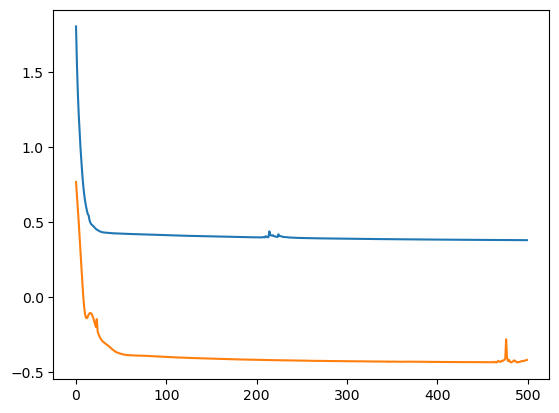

In [79]:
plt.plot(f0.loss)
plt.plot(f1.loss)

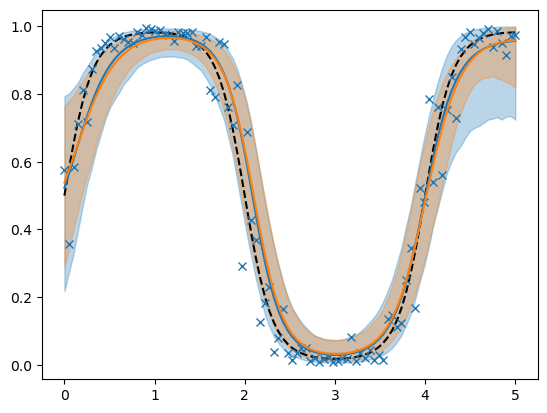

In [83]:
p_true = torch.sigmoid(func(test_x))

samp = f0.model(test_x).sample(torch.Size([1000]))
p0 = torch.sigmoid(samp)

samp = f1.model(test_x).sample(torch.Size([1000]))
p1 = torch.sigmoid(samp)

plt.plot(test_x.numpy(), p_true.numpy(), 'k--')
plt.plot(test_x.numpy(), test_p.numpy(), "x")

plt.plot(test_x.numpy(), p0.mean(dim=0).numpy(), color='tab:blue')
plt.fill_between(test_x.squeeze(1).numpy(), p0.quantile(0.025, dim=0).numpy(), p0.quantile(0.975, dim=0).numpy(), alpha=0.3, color='tab:blue')

plt.plot(test_x.numpy(), p1.mean(dim=0).numpy(), color='tab:orange')
plt.fill_between(test_x.squeeze(1).numpy(), p1.quantile(0.025, dim=0).numpy(), p1.quantile(0.975, dim=0).numpy(), alpha=0.3, color='tab:orange')

In [47]:
# coverage for p
print( torch.sum( (test_p > p0.quantile(0.025, dim=0)) & (test_p < p0.quantile(0.975, dim=0)) ) / 100)
print( torch.sum( (test_p > p1.quantile(0.025, dim=0)) & (test_p < p1.quantile(0.975, dim=0)) ) / 100)

tensor(0.8600)
tensor(0.7000)


In [ ]:
def generate_data(n, seed=1):
    torch.manual_seed(seed)

    x = torch.linspace(0, 5, n)
    func = lambda x: torch.sin(x * (0.5 * math.pi)) * 4
    f = func(x) + math.sqrt(0.4) * torch.randn(n)
    x = x.reshape(-1, 1)
    p = torch.sigmoid(f)
    y = torch.bernoulli(p)

    # split train and test
    idx = torch.randperm(n)
    n_train = int(n * 0.8)

    train_x = x[idx[:n_train]]
    train_y = y[idx[:n_train]]

    test_x = x[idx[n_train:]]
    test_y = y[idx[n_train:]]
    test_p = p[idx[n_train:]]
    test_f = f[idx[n_train:]]
    
    test_x = test_x.reshape(-1, 1)
    true_f = func(test_x)


    return train_x, train_y, test_x, test_y, test_p, test_f, true_f


def analyze_simulation(seed, train_y, train_x, test_y, test_x, test_p, test_f, true_f,
        n_iter=200, n_inducing=50, thresh=1e-6, verbose=False, use_loader=False, batches=20):
    torch.manual_seed(seed)
    print(f"Run: {seed}")
        
    f0 = LogisticGPVI(train_y, train_x, n_inducing=n_inducing, n_iter=n_iter, thresh=thresh, verbose=verbose, 
                            use_loader=use_loader, batches=batches, seed=seed)
    f0.fit()

    f1 = LogisticGPVI(train_y, train_x, likelihood=PGLikelihood(), n_inducing=n_inducing, n_iter=n_iter, thresh=thresh, 
                            verbose=verbose, use_loader=use_loader, batches=batches, seed=seed)
    f1.fit()

    return torch.tensor([
        evaluate_method_simulation(f0, test_y, test_x, test_p, test_f, true_f),
        evaluate_method_simulation(f1, test_y, test_x, test_p, test_f, true_f),
    ])



def evaluate_method_simulation(func, test_y, test_x, test_p, test_f, true_f):
    pred_y = func.predict(test_x)

    auc = BinaryAUROC()
    auc.update(test_y, pred_y)
    auc = auc.compute().item()

    lower, upper = func.credible_intervals(test_x)
    ci_width = (upper - lower).mean().item()

    n = test_y.size()[0]

    f_pred = func.model(test_x).mean
    mse = ((true_f.reshape(-1) - f_pred) ** 2).mean().item()
    
    coverage_f = torch.sum( (test_f > lower) & (test_f < upper) ) / n

    samp = func.model(test_x).sample(torch.Size([1000]))
    p0 = torch.sigmoid(samp)

    lower_p = torch.quantile(p0, 0.025, dim=0)
    upper_p = torch.quantile(p0, 0.975, dim=0)
    
    coverage_p = torch.sum( (test_p > lower_p) & (test_p < upper_p) ) / n

    return func.runtime, auc, ci_width, \
            func.neg_log_likelihood().item(), func.neg_log_likelihood(test_x, test_y).item(), \
            func.log_marginal().item(),             func.log_marginal(test_x, test_y).item(), \
            func.ELB0_MC().item(),                       func.ELB0_MC(test_x, test_y).item(), \
            coverage_f.item(), coverage_p.item(), 

In [ ]:
CPUS = 4
RUNS = 100
n = 250

def run_exp(seed):
    train_x, train_y, test_x, test_y, test_p, test_f = generate_data(n, seed=seed)
    return analyze_simulation(seed, train_y, train_x, test_y, test_x, test_p, test_f, n_iter=200, n_inducing=50)

res = Parallel(n_jobs=CPUS)(delayed(run_exp)(i) for i in range(1, RUNS+1))
res = torch.stack(res)
res = torch.transpose(res, 0, 1)

In [72]:
res = torch.load("../results/gp.pt")

In [73]:
res.mean(dim=1)

tensor([[11.3820,  0.7807,  2.7239, 62.1044, 16.8242, 62.0991, 16.8203, 55.0211,
          7.2042,  0.7926,  0.7830],
        [10.1945,  0.7734,  2.0412, 63.0772, 17.0398, 63.0607, 17.0324, 53.1854,
          5.4272,  0.6312,  0.6166]])